## Dosyaların Bulunması ve Sayılması

`os` kütüphanesi ile verilen klasördeki tüm `.txt` dosyaları arandı. Bulunan dosyaların yolları `label_files` listesine atıldı. Toplamda **1539** tane `.txt` dosyası bulundu.


In [11]:
import os

labels_path = "C:\\Users\\omerp\\Masaüstü\\OtoparkTakipSistemi\\dataset\\labels"
label_files = []
for root, _, files in os.walk(labels_path):
    for file in files:
        if file.endswith(".txt"):
            label_files.append(os.path.join(root, file))


print(f"Toplam .txt dosyası: {len(label_files)}")


Toplam .txt dosyası: 1539


## Bounding Box'ların Sayılması

Bulunan tüm `.txt` dosyaları tek tek açıldı ve içindeki satırlar okundu. Her satır, boşluklardan ayrılarak parçalandı ve geçerli bir satır olup olmadığı kontrol edildi. Sadece 0 veya 1 sınıfına ait etiketler alındı ve bunlar `class_counts` listesine atıldı. Tüm dosyalar incelendikten sonra toplamda **64529** tane bounding box bulundu.


In [12]:
class_counts = []

for file in label_files:
    with open(os.path.join(labels_path, file), "r") as f:
        lines = f.readlines()
        for line in lines:
            parts = line.strip().split()
            if len(parts) == 5 and parts[0] in ["0", "1"]:
                class_counts.append(int(parts[0]))

print(f"Toplam bounding box sayısı: {len(class_counts)}")


Toplam bounding box sayısı: 64529


#  Sınıf Dağılımı Grafiği (Boş vs Dolu)

Bu adımda, tüm etiket dosyalarından toplanan sınıf bilgileri görselleştirilmiştir. `0` sınıfı boş (yeşil), `1` sınıfı ise dolu (kırmızı) park alanlarını temsil eder.

Python'da `Counter` fonksiyonu kullanılarak her sınıftan kaç tane olduğu sayılmış ve matplotlib ile sütun grafiği çizdirilmiştir.

**Grafik Yorumu:**

- **Boş park yerleri (yeşil):** Yaklaşık 26.000 etiket  
- **Dolu park yerleri (kırmızı):** Yaklaşık 38.000 etiket

Bu dağılım, veride dolu park alanlarının sayıca daha fazla olduğunu gösteriyor. Bu durum eğitim sırasında modelin “dolu” sınıfına daha fazla odaklanmasına neden olabilir. İleride dengeleme (örneğin ağırlıklandırma ya da veri artırma) yapılması gerekebilir.


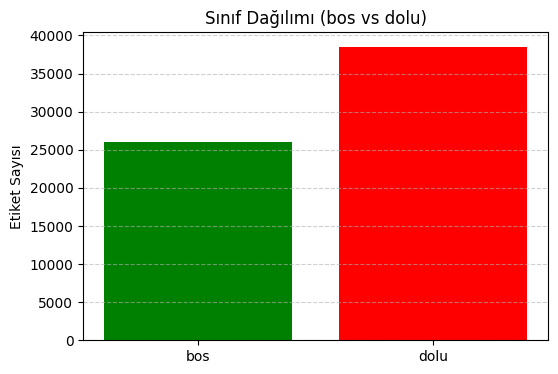

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

class_counter = Counter(class_counts) # Sınıf dağılımı
labels = ['bos', 'dolu']  # Etiketleri isimlendirelim
values = [class_counter.get(0, 0), class_counter.get(1, 0)]


plt.figure(figsize=(6, 4))
plt.bar(labels, values, color=["green", "red"])
plt.title("Sınıf Dağılımı (bos vs dolu)")
plt.ylabel("Etiket Sayısı")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


#  Görsel Başına Etiket (BBox) Sayısı Dağılımı
Bu adımda her bir görselde (etiket dosyasında) kaç adet bounding box olduğunu analiz ettim. Yani, her `.txt` dosyasındaki geçerli satırların sayısını hesapladım. Her satır bir nesneyi temsil ettiğinden bu sayı, o görüntüde kaç adet nesne bulunduğunu gösterir.

**İstatistiksel Sonuçlar:**
- Ortalama bounding box sayısı: **42.00**
- Etiketsiz görsel sayısı: **0**

**Grafik Yorumu:**
Grafikte neredeyse tüm görüntülerin üzerinde 42 adet etiket olduğu görülüyor. Bu da etiketleme işleminin oldukça tutarlı yapıldığını gösteriyor. Her görüntüde benzer sayıda nesne olması, modelin dengeli öğrenmesi açısından olumlu bir durumdur.


Ortalama bbox sayısı: 42.00
Hiç etiketi olmayan görsel sayısı: 0


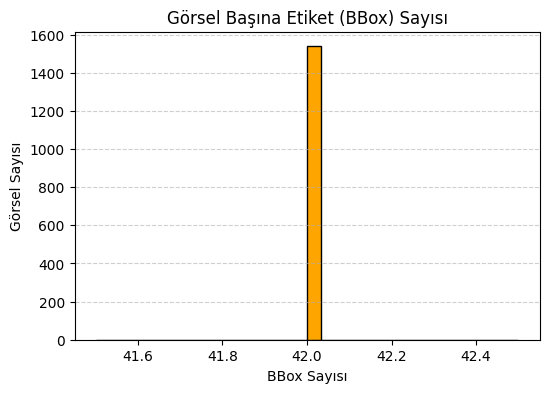

In [16]:
import matplotlib.pyplot as plt

bbox_counts_per_image = []

for file in label_files:
    with open(os.path.join(labels_path, file), "r") as f:
        lines = f.readlines()
        valid_lines = [line for line in lines if len(line.strip().split()) == 5]
        bbox_counts_per_image.append(len(valid_lines))

print(f"Ortalama bbox sayısı: {sum(bbox_counts_per_image)/len(bbox_counts_per_image):.2f}")
print(f"Hiç etiketi olmayan görsel sayısı: {bbox_counts_per_image.count(0)}")


plt.figure(figsize=(6, 4))
plt.hist(bbox_counts_per_image, bins=30, color="orange", edgecolor="black")
plt.title("Görsel Başına Etiket (BBox) Sayısı")
plt.xlabel("BBox Sayısı")
plt.ylabel("Görsel Sayısı")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


#  Donanım Uygunluğu Kontrolü (GPU/CPU)

Bu adımda, model eğitiminin hangi donanımda yapılacağını belirlemek için sistemde **GPU (CUDA)** olup olmadığı kontrol edilmiştir.  

**Sonuç:**
- CUDA desteği: **EVET **
- GPU: **NVIDIA GeForce RTX 3050 Ti Laptop GPU**
- Ancak model hâlâ **CPU** üzerinde çalışmaktadır.

**Yorum:**
Sistem GPU destekli olsa bile, bazen model yüklenirken doğrudan GPU'ya geçmeyebilir. Bu durumda model `.to('cuda')` ile GPU’ya manuel aktarılabilir veya `model.train(device='cuda')` gibi argümanlar kullanılabilir. Eğitim sırasında bu kontrol tekrar yapılmalıdır.


In [ ]:
import torch
from ultralytics import YOLO

# CUDA kullanılabilir mi?
gpu_available = torch.cuda.is_available()
print(f"CUDA (GPU) kullanılabilir mi? ➤ {'EVET ' if gpu_available else 'HAYIR '}")

if gpu_available:
    print(f"Kullanılan GPU: {torch.cuda.get_device_name(0)}")
else:
    print("GPU yok, eğitim CPU ile yapılır.")

# Test modeli oluştur (yalnızca cihaz kontrolü için)
model = YOLO("yolov8n.pt")
print("Model aktif cihazı:", model.device)


CUDA (GPU) kullanılabilir mi? ➤ EVET ✅
Kullanılan GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU


100%|██████████| 6.25M/6.25M [00:02<00:00, 3.07MB/s]


Model aktif cihazı: cpu


#  YOLOv8 Model Eğitimi ve Sonuçların Değerlendirilmesi

Bu adımda, otopark boş/dolu tespiti için YOLOv8 Nano (`yolov8n.pt`) modeli kullanılarak eğitim gerçekleştirilmiştir. Model, `Ultralytics` kütüphanesi üzerinden 50 epoch boyunca eğitilmiş ve çıktılar belirtilen klasöre kaydedilmiştir.

##  Eğitim Parametreleri

- **Veri Seti**: Etiketlerin ve resimlerin bulunduğu `data.yaml` dosyası kullanıldı.
- **Epoch sayısı**: 50 kez tüm veri seti tekrarlandı.
- **Resim Boyutu**: 640x640 piksel
- **Batch Size**: Her işlemde 16 resim kullanıldı.
- **Cihaz**: GPU (NVIDIA RTX 3050 Ti) kullanıldı.
- **Sonuçlar Klasörü**: Eğitim sonuçları, belirtilen klasöre kaydedildi.


Bu durum veri seti temizliği için önemli bir uyarıdır ve etiket dosyalarının gözden geçirilmesini gerektirir.

##  Eğitim Sonuçları (Epoch 50)

| Metrik              | Değer     |
|---------------------|-----------|
| Doğruluk (Precision) | 0.999     |
| Duyarlılık (Recall) | 0.999     |
| mAP@0.5             | 0.995     |
| mAP@0.5:0.95        | **0.979** |

Bu sonuçlar modelin **çok yüksek doğrulukla** çalıştığını ve nesne sınıflarını başarılı bir şekilde ayırt edebildiğini göstermektedir.

##  Sonuç Yorumları

- Eğitim süreci sorunsuz tamamlandı ve `best.pt` ile `last.pt` dosyaları oluşturuldu.
- Model, hem **boş** hem **dolu** sınıflarda yüksek başarı gösterdi.
- Ortalama AP değeri (0.979), modelin her iki sınıfta da güçlü genelleme yeteneğine sahip olduğunu gösteriyor.




#  YOLOv8 Model Seçimi: Neden `yolov8n.pt` Kullanıldı?

YOLOv8 modelleri farklı boyutlarda sunulur. Bu modellerden hangisinin kullanılacağı, veri setinin büyüklüğüne, donanım gücüne ve istenen doğruluk/hız dengesine göre belirlenir.


##  Bu Projede Neden `yolov8n.pt` Seçildi?

-  **Donanım durumu**: Orta seviye bir GPU (RTX 3050 Ti) kullanıldığı için hafif bir model tercih edildi.
-  **Eğitim süresi**: Daha hızlı sonuç almak için nano model kullanıldı.
-  **Yeterli başarı**: Sadece birkaç epoch sonunda mAP değeri %99.5 civarına ulaştı, bu da daha büyük modele gerek bırakmadı.
-  **Zaman ve kaynak tasarrufu**: Büyük modeller eğitimi ciddi oranda uzatır, bu nedenle küçük modelle başlamak daha verimli oldu.

##  Diğer Modeller Ne Zaman Kullanılır?

- Eğer `yolov8n.pt` modeli yeterince iyi sonuç vermezse
- Daha büyük ve karmaşık bir veri seti kullanılırsa
- Detaylı veya yüksek çözünürlüklü nesneler tespit edilecekse
- Üretim ortamında en iyi doğruluk istenirse



In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")  

model.train(
    data="C:\Users\omerp\Masaüstü\OtoparkTakipSistemi\dataset\data.yaml",  
    epochs=50,                      
    imgsz=640,                      
    batch=16,                       
    device=0,                       
    workers=4,                     
    name="yolo_parking_v1",        
    project="C:\Users\omerp\Masaüstü\OtoparkTakipSistemi\yolo_results",  
    exist_ok=True                  
)


New https://pypi.org/project/ultralytics/8.3.130 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.127  Python-3.13.2 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:/parking_dataset_yolo/yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=cuda:0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo_pa

100%|██████████| 5.35M/5.35M [00:03<00:00, 1.42MB/s]


AMP: checks passed 
train: Fast image access  (ping: 0.00.0 ms, read: 37.19.6 MB/s, size: 261.4 KB)


train: Scanning C:\parking_dataset_yolo\yolo_dataset\labels\train... 1231 images, 0 backgrounds, 53 corrupt: 100%|██████████| 1231/1231 [00:01<00:00, 764.58it/s]

train: C:\parking_dataset_yolo\yolo_dataset\images\train\2013-02-22_15_15_09.jpg: ignoring corrupt image/label: could not convert string to float: 'None'
train: C:\parking_dataset_yolo\yolo_dataset\images\train\2013-03-02_12_50_07.jpg: ignoring corrupt image/label: could not convert string to float: 'None'
train: C:\parking_dataset_yolo\yolo_dataset\images\train\2013-03-03_11_25_06.jpg: ignoring corrupt image/label: could not convert string to float: 'None'
train: C:\parking_dataset_yolo\yolo_dataset\images\train\2013-03-03_12_40_07.jpg: ignoring corrupt image/label: could not convert string to float: 'None'
train: C:\parking_dataset_yolo\yolo_dataset\images\train\2013-03-10_14_20_09.jpg: ignoring corrupt image/label: could not convert string to float: 'None'
train: C:\parking_dataset_yolo\yolo_dataset\images\train\2013-03-11_10_25_05.jpg: ignoring corrupt image/label: could not convert string to float: 'None'
train: C:\parking_dataset_yolo\yolo_dataset\images\train\2013-03-11_17_05_13

val: Fast image access  (ping: 0.10.1 ms, read: 26.75.1 MB/s, size: 264.3 KB)


val: Scanning C:\parking_dataset_yolo\yolo_dataset\labels\val... 308 images, 0 backgrounds, 12 corrupt: 100%|██████████| 308/308 [00:00<00:00, 392.02it/s]

val: C:\parking_dataset_yolo\yolo_dataset\images\val\2013-03-02_09_00_03.jpg: ignoring corrupt image/label: could not convert string to float: 'None'
val: C:\parking_dataset_yolo\yolo_dataset\images\val\2013-03-09_11_50_06.jpg: ignoring corrupt image/label: could not convert string to float: 'None'
val: C:\parking_dataset_yolo\yolo_dataset\images\val\2013-03-11_17_00_12.jpg: ignoring corrupt image/label: could not convert string to float: 'None'
val: C:\parking_dataset_yolo\yolo_dataset\images\val\2013-03-15_08_15_02.jpg: ignoring corrupt image/label: could not convert string to float: 'None'
val: C:\parking_dataset_yolo\yolo_dataset\images\val\2013-03-16_17_30_13.jpg: ignoring corrupt image/label: could not convert string to float: 'None'
val: C:\parking_dataset_yolo\yolo_dataset\images\val\2013-03-20_16_00_11.jpg: ignoring corrupt image/label: could not convert string to float: 'None'
val: C:\parking_dataset_yolo\yolo_dataset\images\val\2013-03-20_18_00_13.jpg: ignoring corrupt image

Plotting labels to C:\parking_dataset_yolo\yolo_results\yolo_parking_v1\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to C:\parking_dataset_yolo\yolo_results\yolo_parking_v1
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50       3.4G      1.822      1.952      1.283        607        640: 100%|██████████| 74/74 [00:24<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        296      12432      0.789      0.855      0.957      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.81G      1.143     0.7413     0.9658        994        640: 100%|██████████| 74/74 [00:46<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.57it/s]

                   all        296      12432      0.966      0.968      0.994      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.04G     0.9886     0.6272     0.9187        612        640: 100%|██████████| 74/74 [00:16<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        296      12432      0.993      0.994      0.995       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.07G     0.8966     0.5815     0.8928        779        640: 100%|██████████| 74/74 [00:16<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        296      12432      0.996      0.995      0.995      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.03G     0.8345     0.5365     0.8751        713        640: 100%|██████████| 74/74 [00:16<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.87it/s]

                   all        296      12432      0.995      0.993      0.995      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.54G     0.7436     0.4954     0.8554        914        640: 100%|██████████| 74/74 [00:37<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.57it/s]

                   all        296      12432      0.995      0.996      0.994       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.52G     0.7004     0.4771     0.8476        738        640: 100%|██████████| 74/74 [00:22<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.76it/s]

                   all        296      12432      0.998      0.998      0.995      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.98G     0.6806     0.4566      0.844        676        640: 100%|██████████| 74/74 [00:16<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.77it/s]

                   all        296      12432      0.999      0.998      0.995      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.51G     0.6326     0.4334     0.8348        859        640: 100%|██████████| 74/74 [00:30<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.92it/s]

                   all        296      12432      0.998      0.998      0.995      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.05G      0.626     0.4246     0.8324        832        640: 100%|██████████| 74/74 [00:16<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.78it/s]

                   all        296      12432      0.999      0.999      0.995      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       2.8G     0.6099     0.4101      0.829        958        640: 100%|██████████| 74/74 [00:16<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.71it/s]

                   all        296      12432      0.999      0.999      0.995      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.88G     0.5935     0.4005     0.8277        561        640: 100%|██████████| 74/74 [00:16<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.82it/s]

                   all        296      12432      0.999      0.999      0.995       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.75G     0.5651     0.3847     0.8225        716        640: 100%|██████████| 74/74 [00:16<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.90it/s]

                   all        296      12432      0.998      0.999      0.995      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.26G     0.5709     0.3798     0.8241        979        640: 100%|██████████| 74/74 [00:16<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.72it/s]

                   all        296      12432      0.999      0.999      0.995      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.42G     0.5398     0.3671     0.8168        709        640: 100%|██████████| 74/74 [00:17<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.92it/s]

                   all        296      12432      0.999      0.999      0.995      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.96G     0.5454     0.3681     0.8167        761        640: 100%|██████████| 74/74 [00:16<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.77it/s]

                   all        296      12432      0.999      0.999      0.995      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.08G     0.5206     0.3567     0.8141        667        640: 100%|██████████| 74/74 [00:16<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.73it/s]

                   all        296      12432      0.999      0.999      0.995      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50       3.9G     0.5068     0.3478     0.8102        825        640: 100%|██████████| 74/74 [01:31<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.85it/s]

                   all        296      12432      0.999      0.999      0.995      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.08G      0.478     0.3382     0.8074        511        640: 100%|██████████| 74/74 [00:16<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.89it/s]

                   all        296      12432      0.999      0.999      0.995      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       3.8G     0.4757     0.3342      0.807        877        640: 100%|██████████| 74/74 [00:40<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.62it/s]

                   all        296      12432      0.998      0.999      0.995      0.934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50       2.9G     0.4919     0.3407     0.8085        667        640: 100%|██████████| 74/74 [00:16<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.05it/s]

                   all        296      12432      0.999      0.999      0.995      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.41G     0.4563     0.3237     0.8047        686        640: 100%|██████████| 74/74 [00:18<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.73it/s]

                   all        296      12432      0.999      0.999      0.995       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.92G     0.4925     0.3276     0.8079        644        640: 100%|██████████| 74/74 [00:16<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.86it/s]

                   all        296      12432      0.999      0.999      0.995      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.32G     0.4459      0.314     0.8025        533        640: 100%|██████████| 74/74 [00:16<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.98it/s]

                   all        296      12432      0.998      0.999      0.995      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.26G     0.4422     0.3093     0.8025        892        640: 100%|██████████| 74/74 [00:16<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.80it/s]

                   all        296      12432      0.998      0.999      0.995      0.943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       3.2G     0.4411     0.3075     0.8015        797        640: 100%|██████████| 74/74 [00:16<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.80it/s]

                   all        296      12432      0.999      0.999      0.995       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.75G     0.4439     0.3064      0.802        894        640: 100%|██████████| 74/74 [00:16<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.85it/s]

                   all        296      12432      0.999      0.999      0.995      0.943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.55G     0.4405     0.3028     0.8022        884        640: 100%|██████████| 74/74 [00:37<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.09it/s]

                   all        296      12432      0.999      0.999      0.995      0.948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.74G     0.4162     0.2934     0.7974        840        640: 100%|██████████| 74/74 [00:16<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.08it/s]

                   all        296      12432      0.998          1      0.995      0.948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.99G     0.4218     0.2949      0.799        801        640: 100%|██████████| 74/74 [00:16<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.18it/s]

                   all        296      12432      0.999      0.999      0.995      0.934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50       3.6G     0.4093     0.2922     0.7979        850        640: 100%|██████████| 74/74 [00:32<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.80it/s]

                   all        296      12432      0.999      0.999      0.995      0.948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.78G     0.4035     0.2871     0.7982        557        640: 100%|██████████| 74/74 [00:16<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.82it/s]

                   all        296      12432      0.998      0.999      0.995      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.65G     0.4192     0.2904     0.7972        563        640: 100%|██████████| 74/74 [00:43<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.16it/s]

                   all        296      12432      0.999      0.999      0.995      0.936



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.02G     0.4148      0.288     0.7964        769        640: 100%|██████████| 74/74 [00:16<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        296      12432      0.999      0.999      0.995      0.943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50       3.1G     0.3935       0.28     0.7957        687        640: 100%|██████████| 74/74 [00:17<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.77it/s]

                   all        296      12432      0.999      0.999      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.68G      0.385     0.2767     0.7943        903        640: 100%|██████████| 74/74 [00:47<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.88it/s]

                   all        296      12432      0.999      0.999      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.08G     0.3828     0.2766     0.7952        811        640: 100%|██████████| 74/74 [00:16<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.02it/s]

                   all        296      12432      0.999      0.999      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.17G     0.3717     0.2714     0.7953        910        640: 100%|██████████| 74/74 [00:16<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.91it/s]

                   all        296      12432      0.999      0.999      0.995      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.66G      0.381     0.2736     0.7932        906        640: 100%|██████████| 74/74 [00:16<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.96it/s]

                   all        296      12432      0.999      0.999      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       3.3G     0.3669     0.2663     0.7923        721        640: 100%|██████████| 74/74 [00:16<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.90it/s]

                   all        296      12432      0.999      0.999      0.995      0.961


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.05G     0.3662     0.2713      0.784        414        640: 100%|██████████| 74/74 [00:14<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.77it/s]

                   all        296      12432      0.999      0.999      0.995       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.04G     0.3305     0.2476     0.7797        412        640: 100%|██████████| 74/74 [00:14<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.96it/s]

                   all        296      12432      0.999      0.999      0.995      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.05G     0.3178     0.2403     0.7791        408        640: 100%|██████████| 74/74 [00:14<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.61it/s]

                   all        296      12432      0.999      0.999      0.995      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.04G     0.3144      0.236     0.7792        418        640: 100%|██████████| 74/74 [00:14<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.09it/s]

                   all        296      12432      0.999      0.999      0.995      0.972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.05G     0.2983     0.2299      0.776        414        640: 100%|██████████| 74/74 [00:14<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.07it/s]

                   all        296      12432      0.999      0.999      0.995      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.04G     0.3026     0.2297     0.7769        403        640: 100%|██████████| 74/74 [00:14<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.88it/s]

                   all        296      12432      0.999      0.999      0.995      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.05G     0.2805     0.2222     0.7752        408        640: 100%|██████████| 74/74 [00:14<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.77it/s]

                   all        296      12432      0.998      0.999      0.995      0.972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.04G     0.2782     0.2208      0.775        407        640: 100%|██████████| 74/74 [00:14<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.82it/s]

                   all        296      12432      0.999      0.999      0.995      0.976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.05G     0.2786      0.221      0.775        407        640: 100%|██████████| 74/74 [00:14<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.02it/s]

                   all        296      12432      0.999      0.999      0.995      0.976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.04G     0.2638     0.2147     0.7737        403        640: 100%|██████████| 74/74 [00:14<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.06it/s]

                   all        296      12432      0.999      0.999      0.995      0.979



50 epochs completed in 0.341 hours.
Optimizer stripped from C:\parking_dataset_yolo\yolo_results\yolo_parking_v1\weights\last.pt, 6.2MB
Optimizer stripped from C:\parking_dataset_yolo\yolo_results\yolo_parking_v1\weights\best.pt, 6.2MB

Validating C:\parking_dataset_yolo\yolo_results\yolo_parking_v1\weights\best.pt...
Ultralytics 8.3.127  Python-3.13.2 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


                   all        296      12432      0.999      0.999      0.995      0.979
                   bos        226       4998      0.999      0.999      0.995      0.978
                  dolu        252       7434      0.999      0.999      0.995       0.98
Speed: 0.4ms preprocess, 1.6ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to C:\parking_dataset_yolo\yolo_results\yolo_parking_v1


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000020EDCFD95C0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0

#  Eğitilen Modelin Doğrulama Görselleri Üzerinde Tahmin Yapması

Bu adımda, eğitim sonucu elde edilen **en iyi model (`best.pt`)**, doğrulama görselleri (`val`) üzerinde test edilmiştir. YOLOv8’in `predict()` fonksiyonu kullanılarak görseller üzerinde tahmin yapılmış ve sonuçlar kaydedilmiştir.

## Kullanılan Parametreler

- `model`: Eğitimden gelen `best.pt` modeli (`./yolo_results/...`)
- `source`: Doğrulama görüntüleri klasörü (`./dataset/images/val`)
- `save=True`: Tahmin edilen görseller `.jpg` olarak kaydedilir
- `save_txt=True`: YOLO formatında `.txt` çıktıları da oluşturulur
- `project`: Tüm sonuçlar belirtilen `./inference_results/val_predictions` klasörüne yazılır
- `name`: Tahmin çıktılarının alt klasör adı
- `imgsz=640`: Görseller tahmin sırasında 640x640 olarak yeniden boyutlandırılır

In [ ]:
from ultralytics import YOLO

model = YOLO("./yolo_results/yolo_parking_v1/weights/best.pt")
model.predict(
    source="./dataset/images/val",
    save=True,
    save_txt=True,
    project="./inference_results/val_predictions",
    name="val_predictions",
    imgsz=640
)



image 1/308 c:\Users\omerp\Masast\OtoparkTakipSistemi\dataset\images\val\2013-02-22_06_15_00.jpg: 384x640 40 boss, 2 dolus, 58.7ms
image 2/308 c:\Users\omerp\Masast\OtoparkTakipSistemi\dataset\images\val\2013-02-22_07_10_01.jpg: 384x640 33 boss, 9 dolus, 7.5ms
image 3/308 c:\Users\omerp\Masast\OtoparkTakipSistemi\dataset\images\val\2013-02-22_08_55_02.jpg: 384x640 42 dolus, 7.5ms
image 4/308 c:\Users\omerp\Masast\OtoparkTakipSistemi\dataset\images\val\2013-02-22_09_00_03.jpg: 384x640 42 dolus, 8.4ms
image 5/308 c:\Users\omerp\Masast\OtoparkTakipSistemi\dataset\images\val\2013-02-22_10_00_04.jpg: 384x640 42 dolus, 15.1ms
image 6/308 c:\Users\omerp\Masast\OtoparkTakipSistemi\dataset\images\val\2013-02-22_11_10_05.jpg: 384x640 3 boss, 39 dolus, 7.9ms
image 7/308 c:\Users\omerp\Masast\OtoparkTakipSistemi\dataset\images\val\2013-02-22_11_50_06.jpg: 384x640 8 boss, 34 dolus, 7.7ms
image 8/308 c:\Users\omerp\Masast\OtoparkTakipSistemi\dataset\images\val\2013-02-22_11_55_06.jpg: 384x640 7 bos

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'bos', 1: 'dolu'}
 obb: None
 orig_img: array([[[ 85,  92,  77],
         [ 89,  98,  88],
         [ 97, 107, 107],
         ...,
         [ 10,  24,  30],
         [  8,  22,  28],
         [  7,  21,  27]],
 
        [[ 66,  75,  62],
         [ 72,  80,  73],
         [ 71,  83,  85],
         ...,
         [ 12,  24,  30],
         [ 11,  23,  29],
         [ 10,  22,  28]],
 
        [[ 48,  59,  51],
         [ 52,  63,  60],
         [ 50,  62,  64],
         ...,
         [ 14,  25,  29],
         [ 16,  25,  29],
         [ 15,  24,  28]],
 
        ...,
 
        [[ 38,  45,  64],
         [ 39,  47,  64],
         [ 41,  49,  66],
         ...,
         [ 59,  81,  92],
         [ 58,  83,  93],
         [ 57,  84,  94]],
 
        [[ 36,  46,  63],
         [ 37,  48,  62],
         [ 37,  48,  62],
         ...,
         [

#  Eğitim Sürecine Ait Performans Grafiklerinin Yorumu

Bu görselde, YOLOv8 modelinin eğitim sürecine ait farklı metriklerin değişimi gösterilmiştir. Grafiklerde hem eğitim (train) hem doğrulama (val) süreci izlenebilir.

##  Kayıp Fonksiyonu (Loss) Grafikleri

- `train/box_loss`, `val/box_loss`: Kutu koordinatlarını öğrenme başarısı. Zamanla azalmış, bu iyi bir işarettir.
- `train/cls_loss`, `val/cls_loss`: Sınıf tahmin hataları. Düşüş göstermesi, modelin sınıfları iyi ayırt ettiğini gösterir.
- `train/dfl_loss`, `val/dfl_loss`: Dağıtılmış odak kaybı. Daha düzgün kutu tahminleri için düşmesi beklenir.

>  Genel olarak tüm kayıplar zamanla azalmış, bu da modelin başarıyla öğrendiğini gösteriyor.

##  Değerlendirme Metrikleri

- `metrics/precision(B)`: Modelin “doğru tespit” oranı neredeyse %100'e yakın.
- `metrics/recall(B)`: Modelin tüm nesneleri bulma oranı %99+ seviyesinde.
- `metrics/mAP50(B)`: %99.5 üzerinde; bu da tespitlerin kutularla yüksek uyumlu olduğunu gösterir.
- `metrics/mAP50-95(B)`: %97.9 civarına ulaşarak genel başarıyı gösterir. Bu değer en kritik metriktir.

##  Genel Yorum

Model, her sınıfta (boş/dolu) oldukça yüksek doğrulukla nesne tespiti yapmaktadır. Kayıp fonksiyonlar stabil bir şekilde azalmış, mAP değerleri ise yüksek bir seviyeye oturmuştur.

Bu grafikler, modelin **overfitting** yapmadığını ve başarılı bir eğitim süreci geçirdiğini gösteriyor.


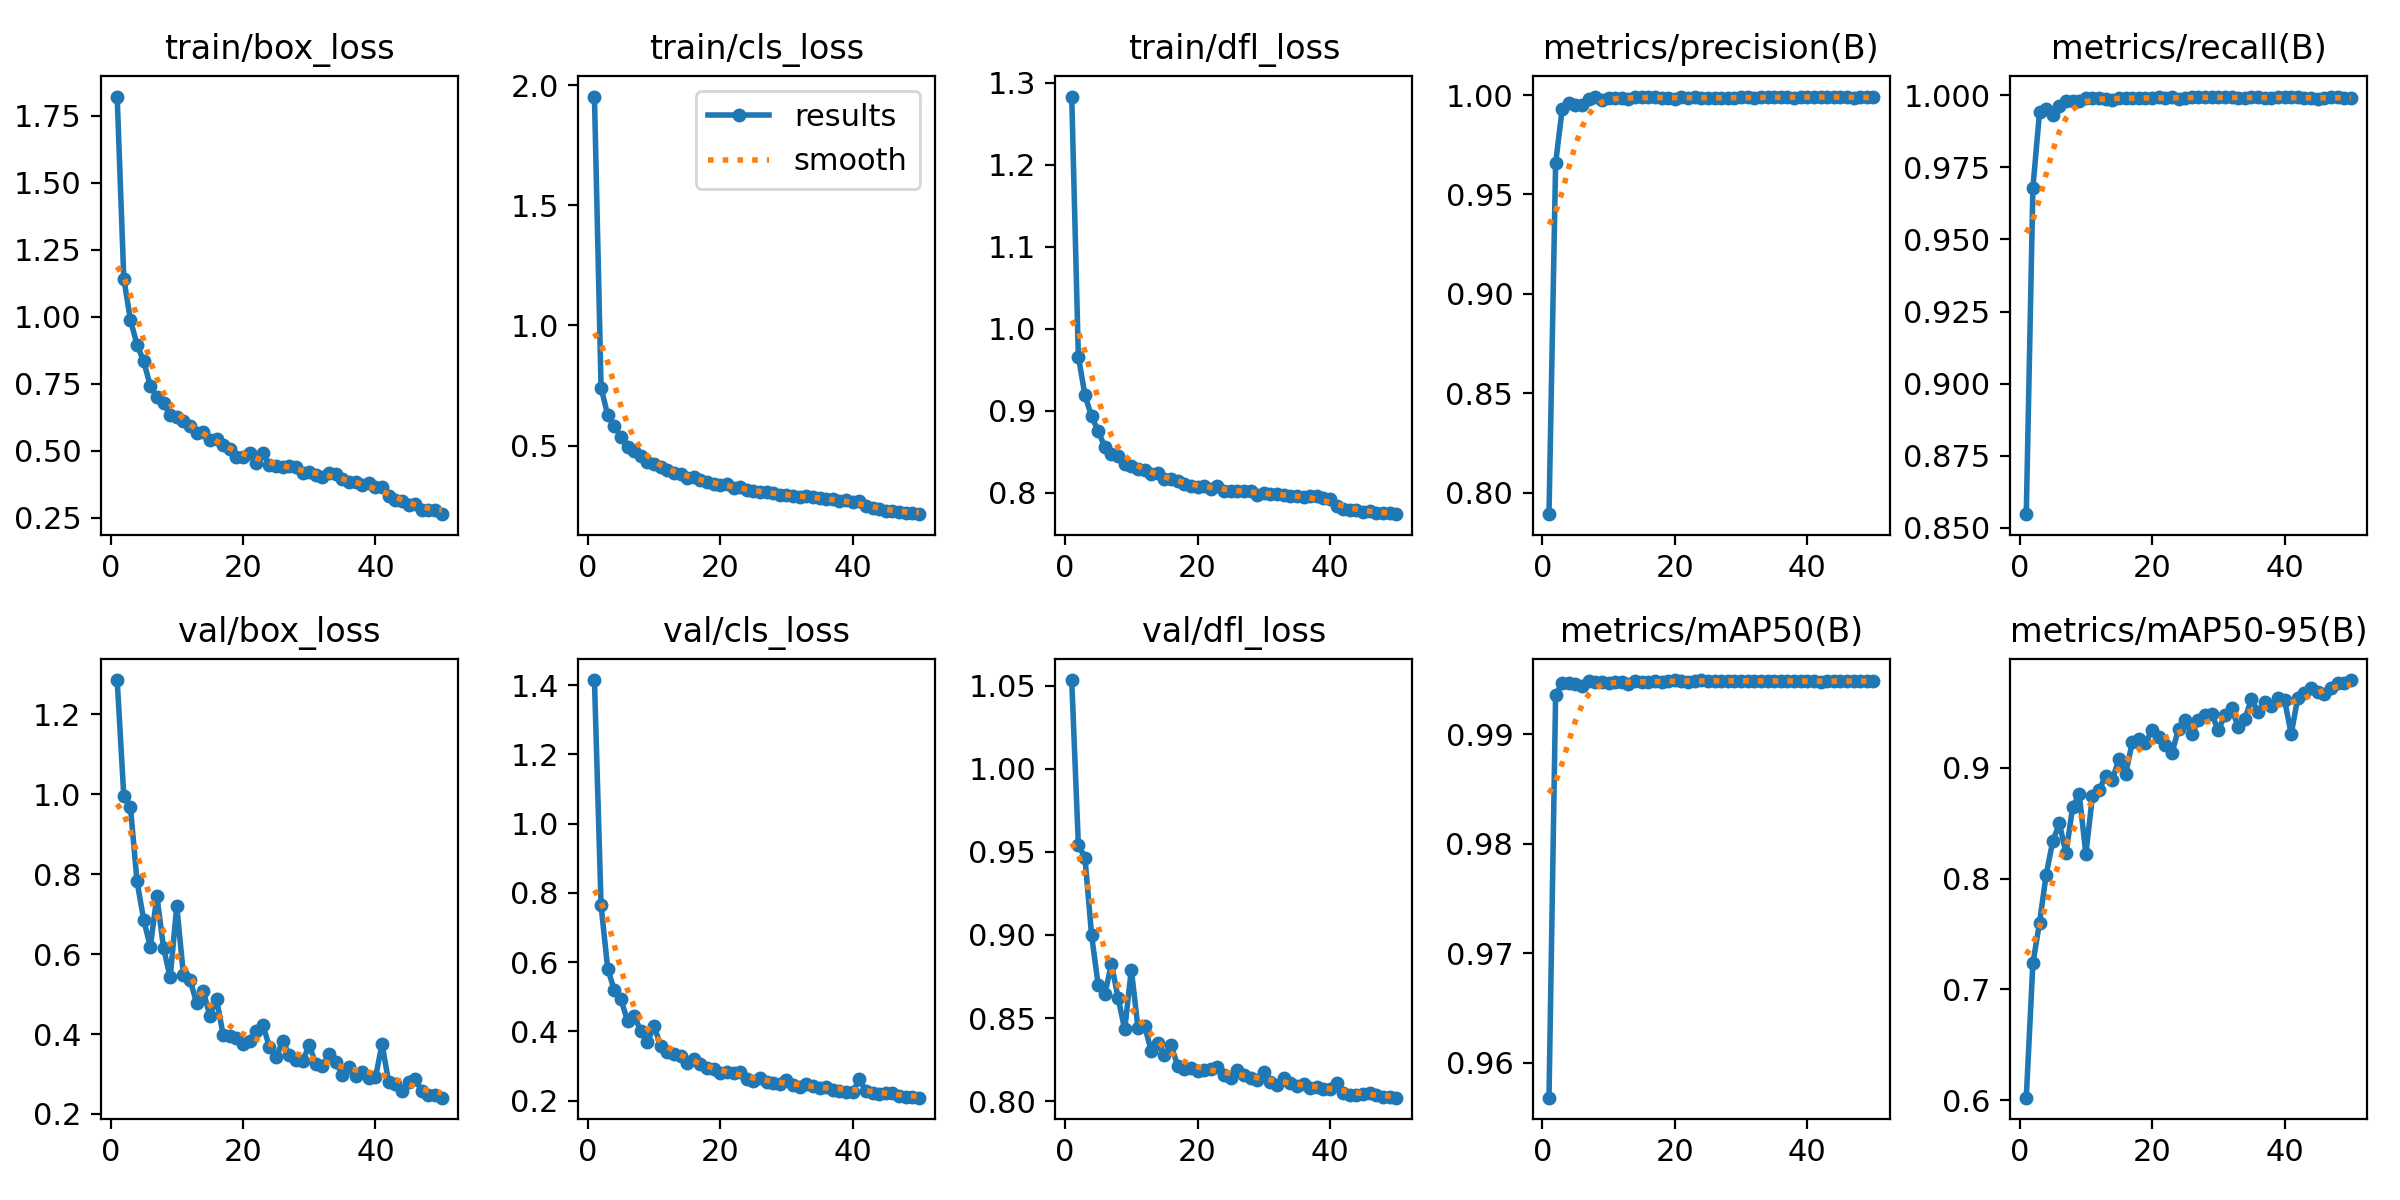

In [ ]:
from IPython.display import Image, display

results_path = "./yolo_results/yolo_parking_v1/metrics/results.png"
display(Image(filename=results_path))


#  Confusion Matrix (Karmaşıklık Matrisi) Analizi

Aşağıdaki görselde, YOLOv8 modelinin **boş** ve **dolu** park alanlarını ne kadar doğru sınıflandırdığı gösterilmiştir.  
Bu matris, tahmin edilen sınıflarla gerçek sınıfların karşılaştırılmasını sağlar.

##  Matris Yorumları

| Gerçek / Tahmin | Pred: boş | Pred: dolu |
|------------------|-----------|------------|
| **Gerçek boş**   | 4985      | 19         |
| **Gerçek dolu**  | 13        | 7428       |

###  Değerlendirme

-  **4985** boş alan doğru sınıflandırılmış.
-  **7428** dolu alan doğru sınıflandırılmış.
-  **19** boş alan hatalı şekilde "dolu" olarak tahmin edilmiş.
-  **13** dolu alan hatalı şekilde "boş" olarak tahmin edilmiş.

##  Sonuç

Model, hem "boş" hem de "dolu" sınıfları çok yüksek doğrulukla tahmin edebilmektedir.  
Bu da eğitimde elde edilen yüksek **precision**, **recall** ve **mAP** değerlerini desteklemektedir.


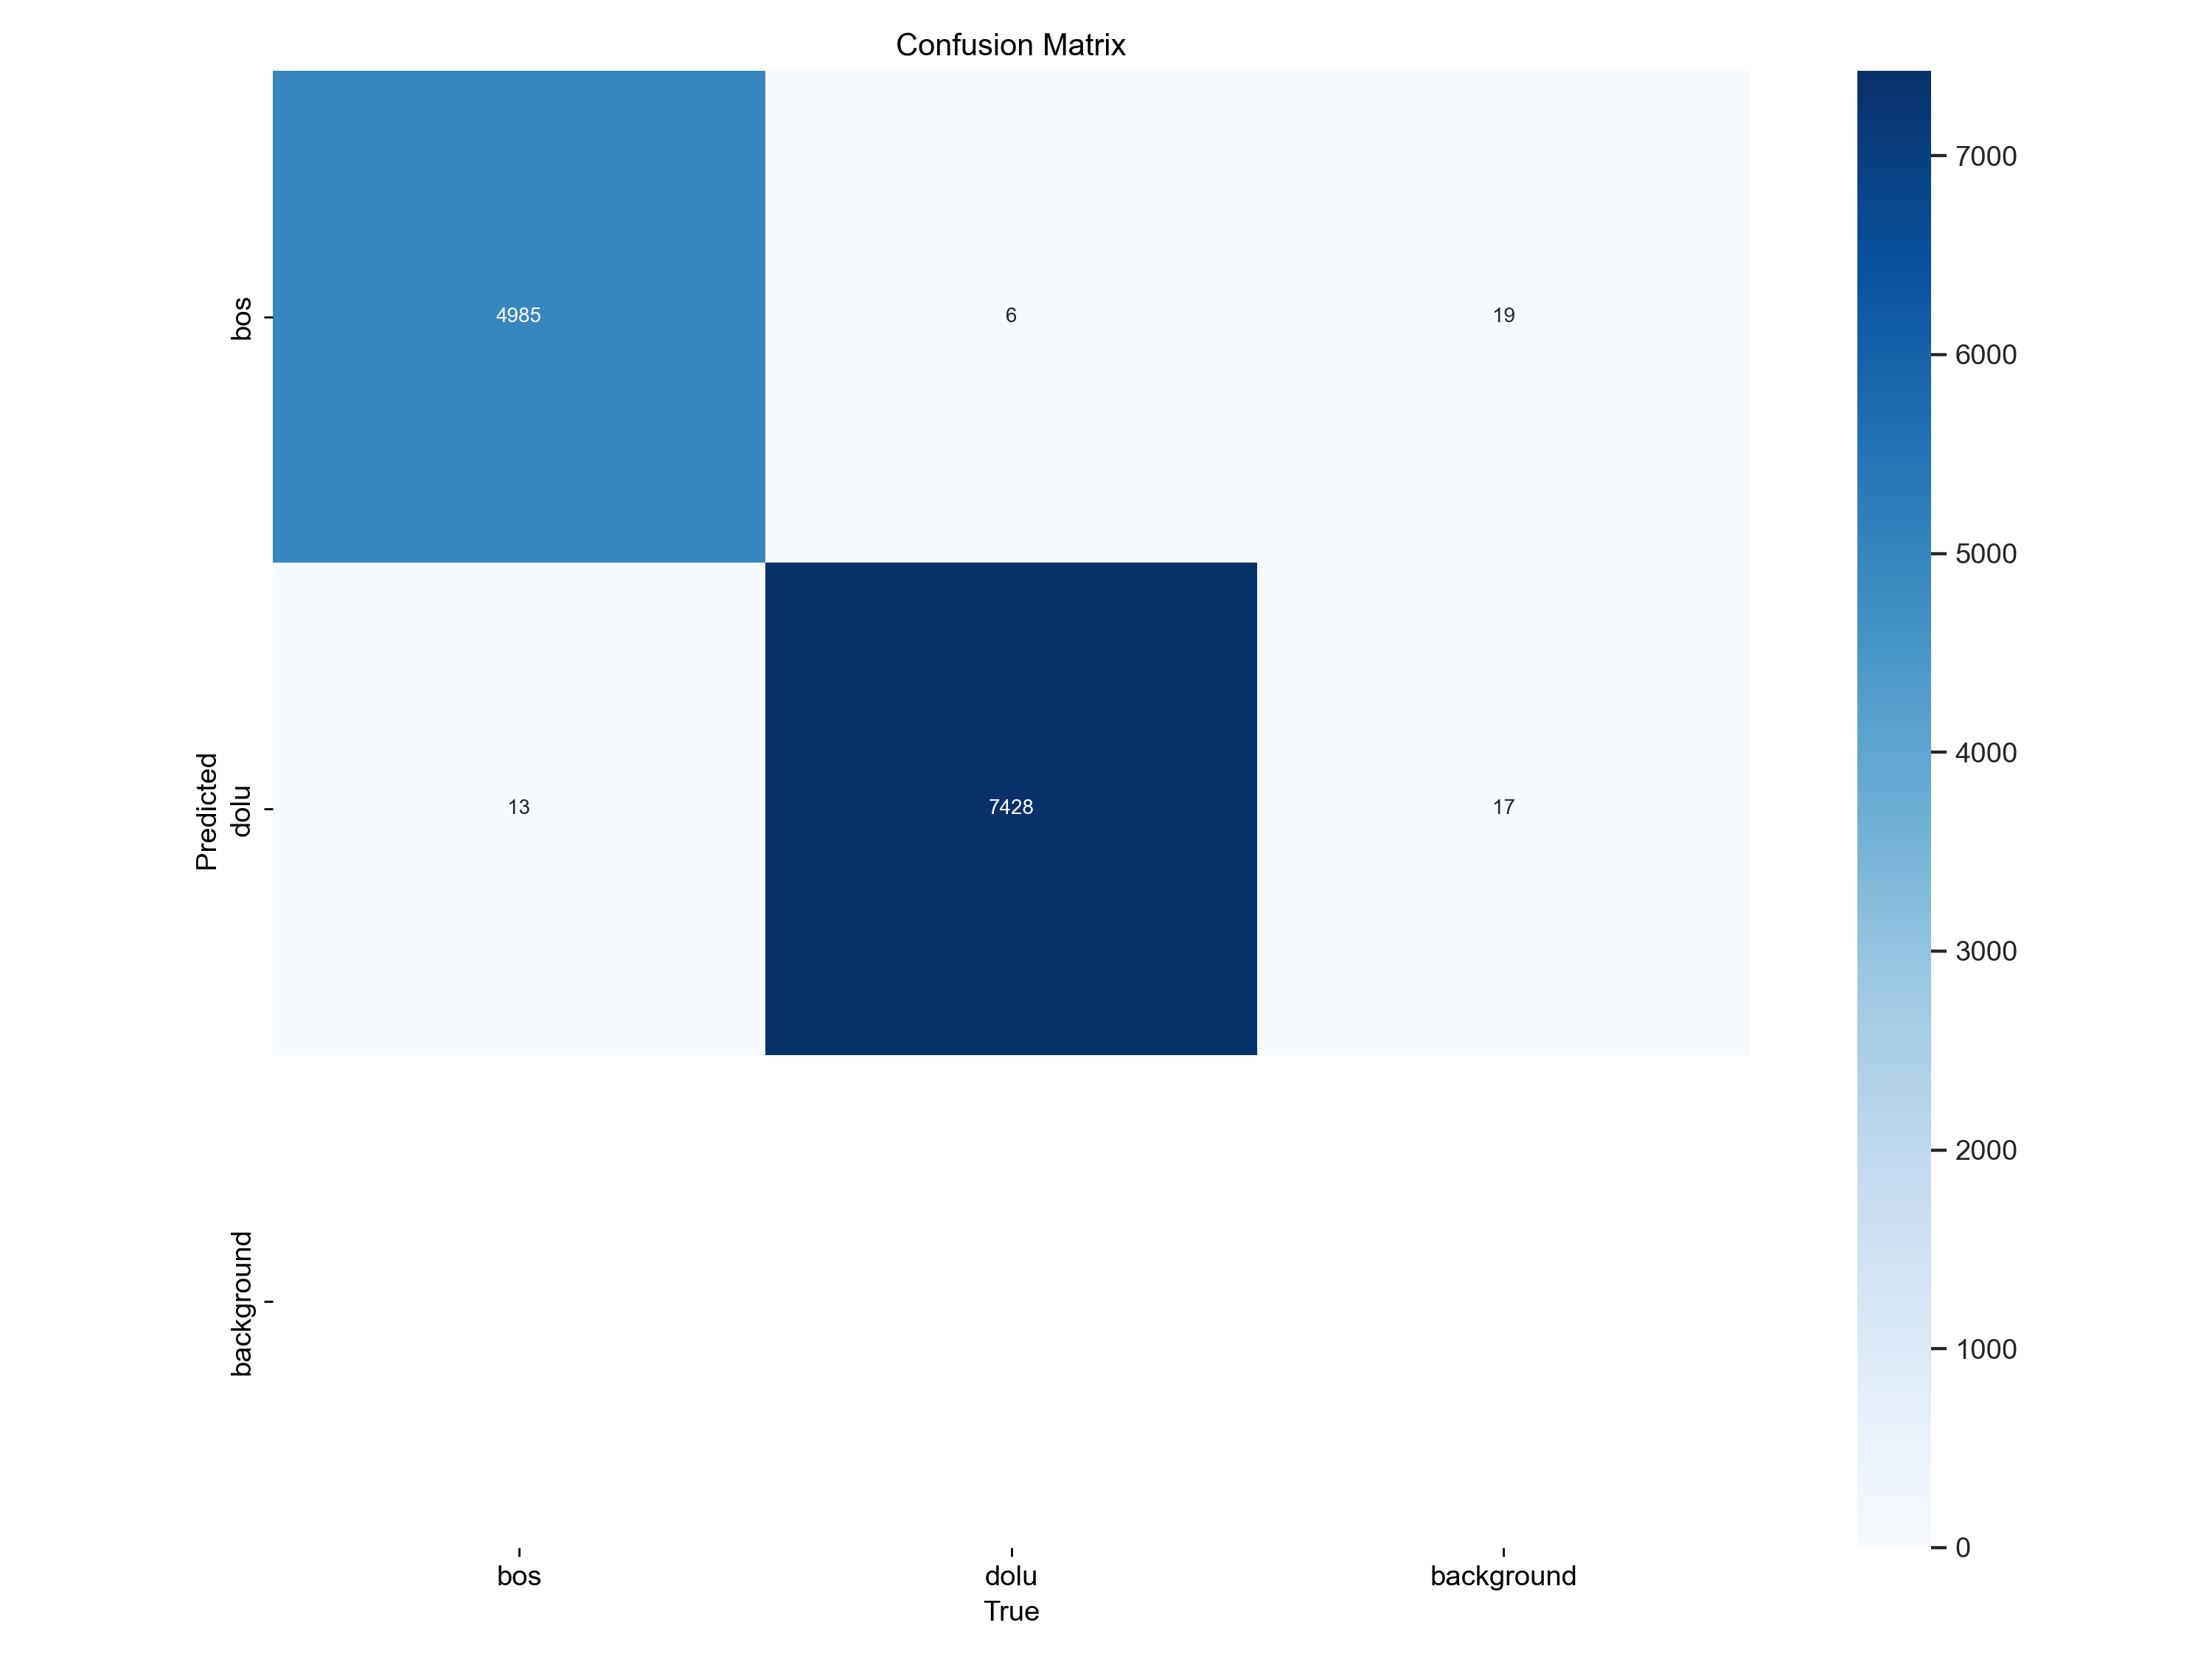

In [ ]:
from IPython.display import Image, display
confusion_matrix_path = "./yolo_results/yolo_parking_v1/metrics/confusion_matrix.png"
display(Image(filename=confusion_matrix_path))
